# Plotting temperature and photosynthesis-related GO term counts, normalised by number of InterPro annotations, for Tara Oceans project PRJEB1787.

The following task shows how to analysie metadata and annotations retrieved from the EMG API and combined on the fly to generate the visualisations.

In [1]:
import copy
try:
    from urllib import urlencode
except ImportError:
    from urllib.parse import urlencode
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from jsonapi_client import Session, Filter

API_BASE = 'https://www.ebi.ac.uk/metagenomics/api/v0.2/'

List all runs
https://www.ebi.ac.uk/metagenomics/api/v0.2/runs?experiment_type=metagenomic&study_accession=ERP001736

In [3]:
def find_metadata(metadata, key):
    """
    Extract metadata value for given key
    """
    for m in metadata:
        if m.var_name.lower() == key.lower():
            return m.var_value
    return None


metadata_key = 'temperature'
normilize_key = 'Predicted CDS with InterProScan match'

# map GO terms to the temperature
result = {}


with Session(API_BASE) as s:

    # temporary dict to store accession and metadata
    metadata_map = {}
    # list of runs missing metadata
    missing_meta = list()
    
    print('Loading data from API.', end='', flush=True)

    # preparing url
    params = {
        'experiment_type': 'metagenomic',
        'study_accession': 'ERP001736',
    }
    f = Filter(urlencode(params))
    # list runs
    for run in s.iterate('runs', f):
        print('.', end='', flush=True)

        # find temperature for each run
        m_value = int(float(find_metadata(run.sample.metadata, metadata_key)))
        if m_value is not None:
            metadata_map[run.accession] = m_value
        else:
            # missing value, skip run!
            missing_meta.append(run.accession)
            continue

        # list analysis results for each run
        for anls in run.analysis:
            
            _pcds = int(find_metadata(anls.metadata, normilize_key))
            if _pcds is None:
                # missing value, skip run!
                continue

            _temperature = metadata_map[anls.accession]
            try:
                result[_temperature]
            except KeyError:
                result[_temperature] = {}

            # list a summary of GO terms derived from InterPro matches
            rt = "runs/%s/pipelines/%s/go-slim" % (anls.accession, anls.pipeline_version)
            af = Filter(urlencode({'page_size': 100}))
            for ann in s.iterate(rt, af):
                try:
                    result[_temperature][ann.accession]
                except KeyError:
                    result[_temperature][ann.accession] = list()
                # normalize annotation counts, adjusting value
                _norm = int(ann.count)/_pcds
                # assign value
                result[_temperature][ann.accession].append(_norm)

    print("DONE")
    print("Missing: ", missing_meta)

Loading data from API..........................................................................................................................................................................................................................................................DONE
Missing:  []


### Clean up data

In [4]:
# remove invalid temperatures
for k in copy.deepcopy(list(result.keys())):
    if k > 2000:
        del result[k]
# average value of the same temperature
for k in result:
    for k1 in result[k]:
        result[k][k1] = np.mean(result[k][k1])

### Plot

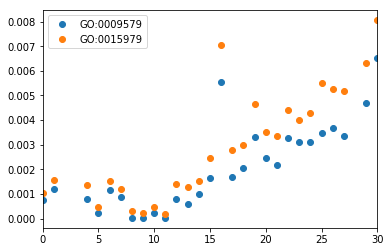

In [5]:
df = DataFrame(result)
df_go = df.T[['GO:0009579','GO:0015979']].copy()
df_go = df_go.dropna()

df_go.plot(y=['GO:0009579', 'GO:0015979'], use_index=True, style='o')

plt.show()

### Calculate correlation

In [6]:
from scipy.stats import spearmanr
x = df_go.index.tolist()
correl = []
correl_p = []
for k in df_go.keys():
    y = list(df_go[k])
    rho, p = spearmanr(x, y)

    correl.append(rho)
    correl_p.append(p)
df_go.loc['rho'] = correl
df_go.loc['p'] = correl_p

In [7]:
df_go

,GO:0009579,GO:0015979
0,7.574880e-04,1.044502e-03
1,1.214248e-03,1.547666e-03
4,7.854478e-04,1.356231e-03
5,2.266193e-04,4.554714e-04
6,1.139834e-03,1.537404e-03
7,8.883851e-04,1.211750e-03
8,2.530999e-05,3.155513e-04
9,3.847138e-05,2.080294e-04
10,2.418478e-04,4.795358e-04
11,2.817284e-05,2.011906e-04
